In [2]:
# Import the necessary modules.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read the csv data file.
df = pd.read_csv('Uber Request Data.csv')

# Let's take a peek at the dataset.
print(df.info())
df.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB
None


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47
5,3879,Airport,1.0,Trip Completed,13-07-2016 21:57:28,13-07-2016 22:28:59
6,4270,Airport,1.0,Trip Completed,14-07-2016 06:15:32,14-07-2016 07:13:15
7,5510,Airport,1.0,Trip Completed,15-07-2016 05:11:52,15-07-2016 06:07:52
8,6248,City,1.0,Trip Completed,15-07-2016 17:57:27,15-07-2016 18:50:51
9,267,City,2.0,Trip Completed,11/7/2016 6:46,11/7/2016 7:25


### Data Cleaning

In [5]:
# Before we proceed, let's convert string values to timestamps in time-related columns.

df['Request timestamp'] = pd.to_datetime(df['Request timestamp'], dayfirst=True)
df['Drop timestamp'] = pd.to_datetime(df['Drop timestamp'], dayfirst=True)
df.head(10)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47
5,3879,Airport,1.0,Trip Completed,2016-07-13 21:57:28,2016-07-13 22:28:59
6,4270,Airport,1.0,Trip Completed,2016-07-14 06:15:32,2016-07-14 07:13:15
7,5510,Airport,1.0,Trip Completed,2016-07-15 05:11:52,2016-07-15 06:07:52
8,6248,City,1.0,Trip Completed,2016-07-15 17:57:27,2016-07-15 18:50:51
9,267,City,2.0,Trip Completed,2016-07-11 06:46:00,2016-07-11 07:25:00


In [6]:
df['Request id'].nunique()==len(df)

True

All the `Request id` are unique (as it should be). So, it's safe to say that this data set has no duplicates. Although `Driver id` and `Drop timestamp` has null values. Let's dig in a little deeper and find out why.

In [7]:
# Let's see various values of the `Status` column.

df['Status'].value_counts() # we only have three types of sstatus.

Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

`Driver id` and `Drop timestamp` must be null when the trip wasn't completed. Let's find out if that's the case.

In [8]:
print(df[df['Driver id'].isnull()]['Status'].value_counts())
df[df['Drop timestamp'].isnull()]['Status'].value_counts()

No Cars Available    2650
Name: Status, dtype: int64


No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

The reason for null values is exactly what we expected. `Driver id` is null, only when no cars were available. `Drop timestamp` is null when either no cars were available or when the trip was cancelled. Trip may either be cancelled by driver or by the customer.We don't know that yet. Also, no cars were available almost <b>twice</b> the number of cancelled rides.

In [9]:
# This function rounds to nearest hour. For example, 15:20 will be 15, 13:40 will be 14, 7:05 will be 7, 8:35 will be 8.

def round_hour(dt):
    #Let's assume dt is 8:35:00
    dt_start_hour = dt.replace(minute=0, second=0, microsecond=0) #This will be 8:00:00
    dt_half_hour = dt.replace(minute=30, second=0, microsecond=0) #This will be 8:30:00

    if dt >= dt_half_hour: #This condition will be true for our example. 8:35:00 > 8:30:00
        # round up
        dt = dt_start_hour + datetime.timedelta(hours=1) #This will be 9:00:00
    else: #This won't be executed for our example.
        # round down
        dt = dt_start_hour

    return dt.hour #This will return 9

In [10]:
# This function returns the time window of the day. For example, 6 AM to 11 AM is morning rush hour.

def slot_of_day(time):
    if time in range(5,13):    # 5 AM to 12 Noon
        return 'Morning'
    elif time in range(13,18): # 1 PM to 5 PM
        return 'Afternoon'
    elif time in range(18,23): # 6 PM to 10 PM
        return 'Evening'
    else:                      # 11 PM to 4 AM
        return 'Night'

In [11]:
# Let's derive some time related columns before we proceed any further.

day_name_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

df['req_day'] = df['Request timestamp'].dt.dayofweek.map(day_name_dict) # which day was it? monday, tuesday,...
df['req_hour'] = df['Request timestamp'].map(lambda x: round_hour(x)) # when was the booking requested? 5AM,6AM,7AM,...
df['req_slot'] = df['req_hour'].map(lambda x: slot_of_day(x)) # when was the booking requested? morning, afternoon,...
df['travel_time'] = (df['Drop timestamp'] - df['Request timestamp']).astype('timedelta64[m]') # travel time in minutes.
#df['req_weekend'] = (df['Request timestamp'].dt.dayofweek // 5 == 1).astype(np.int) # was it a weekend? {0: 'No', 1: 'Yes'}

df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,req_day,req_hour,req_slot,travel_time
26,5434,City,3.0,Trip Completed,2016-07-15 02:41:38,2016-07-15 03:24:43,Friday,3,Night,43.0
34,4075,City,4.0,Trip Completed,2016-07-14 02:17:35,2016-07-14 03:21:38,Thursday,2,Night,64.0
48,6690,Airport,5.0,Trip Completed,2016-07-15 22:41:41,2016-07-15 23:51:00,Friday,23,Night,69.0
53,4081,Airport,6.0,Trip Completed,2016-07-14 02:37:14,2016-07-14 03:30:27,Thursday,3,Night,53.0
56,6758,Airport,6.0,Trip Completed,2016-07-15 00:03:39,2016-07-15 01:07:39,Friday,0,Night,64.0
62,4105,City,7.0,Trip Completed,2016-07-14 03:39:38,2016-07-14 04:39:04,Thursday,4,Night,59.0
75,1346,Airport,9.0,Trip Completed,2016-07-11 23:39:00,2016-07-12 00:23:00,Monday,0,Night,44.0
81,4023,City,9.0,Trip Completed,2016-07-13 23:58:41,2016-07-14 00:58:39,Wednesday,0,Night,59.0
82,4117,City,9.0,Trip Completed,2016-07-14 04:21:42,2016-07-14 05:07:07,Thursday,4,Night,45.0
101,45,Airport,12.0,Trip Completed,2016-07-11 03:17:00,2016-07-11 04:09:00,Monday,3,Night,52.0


Our data seems clean. So we can proceed further now.<br> <b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

### Plotting

count    2831.000000
mean       52.119039
std        13.854735
min        20.000000
25%        41.000000
50%        52.000000
75%        64.000000
max        83.000000
Name: travel_time, dtype: float64


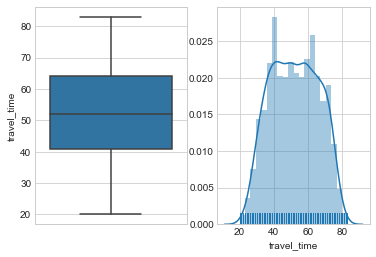

<Figure size 432x288 with 0 Axes>

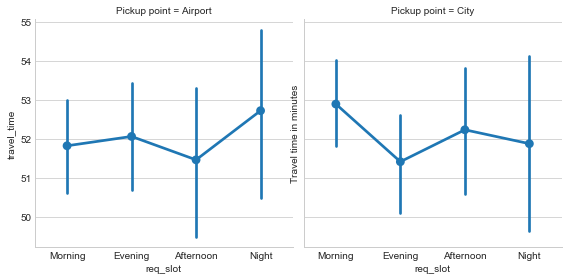

In [12]:
# Let's look at the usual travel time. Maybe if it has some outliers....

print(df.travel_time.describe())
sns.set_style('whitegrid')

plt.figure(1)
plt.subplot(1, 2, 1)
sns.boxplot(y=df['travel_time'])

plt.subplot(1, 2, 2)
sns.distplot(df['travel_time'].dropna(), rug=True)

# Travel time variablility throughout different time slots.
plt.figure(2)
sns.factorplot(data=df, x='req_slot', y='travel_time', col='Pickup point')
plt.ylabel('Travel time in minutes')

plt.show()

We can say that travel time has a fairly even distribution. Both the mean and median values are equally representative of the overall travel time. Also, there isn't much spread in the inter-quartile distance. We can say that it usually takes about an hour for a ride.

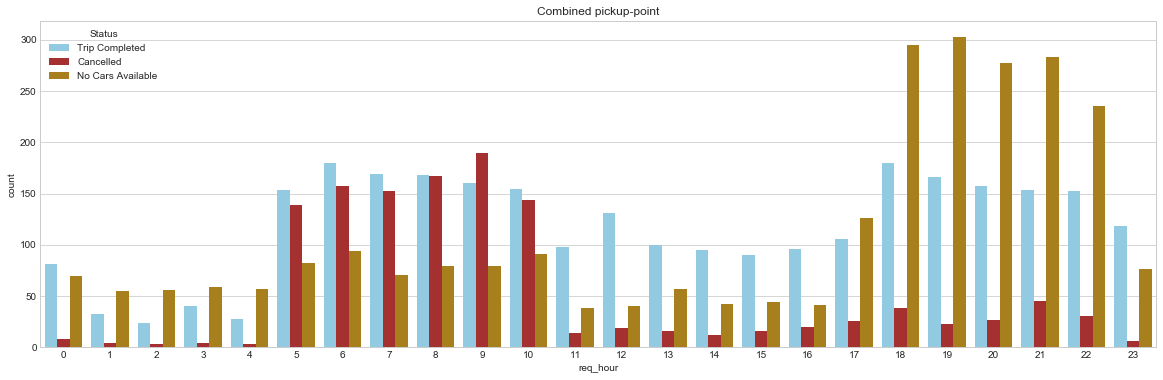

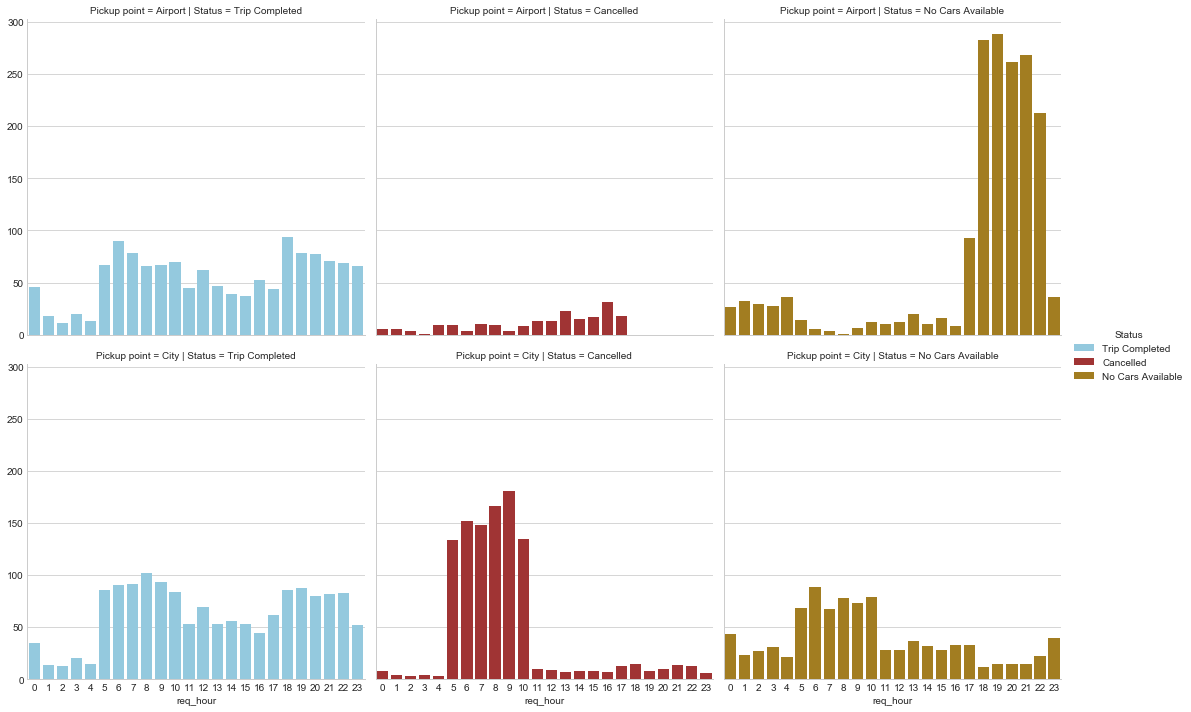

In [13]:
# Let's compare frequency of rides (completed as well as not completed) at various hours of the day.

# 1. (Airport -> City and City -> Airport) combined plot.
plt.figure(1,figsize=(20,6))
plt.title('Combined pickup-point')
palette ={'Trip Completed':'skyblue', 'Cancelled':'firebrick', 'No Cars Available':'darkgoldenrod'}
sns.countplot(x='req_hour', data=df, hue='Status', palette=palette, saturation=.8)

# 2. Segmented plot according to Pickup point.
g = sns.FacetGrid(df, row='Pickup point', col='Status', hue='Status', palette=palette, size=5)
g.map(sns.countplot, "req_hour").add_legend()

# Other ways to make the similar plot 1.
# 1st
#plt.figure(3)
#g = sns.FacetGrid(df, hue="Status", size=5, palette=palette)
#g = g.map(sns.distplot, "req_hour").add_legend()
# 2nd
#plt.figure(4)
#sns.pairplot(df[["req_hour", "Status"]], hue="Status", size=5, palette=palette).add_legend()

plt.show()

It's clear from the above plots that we have issues in <b>morning and night</b> hours.<br>1. Let's observe <b>'Airport to City'</b>. Here the major problem seems to be of <b>car availability</b> in the <b>5:00 PM to 12:00 PM slot (evening till night)</b>. Also we see problem in <b>12:00 PM to 4:00 AM slot (late night and early morning)</b>. I am sure the bars corresponding to `No Cars Available` in both the mentioned slots would be comparable, only if people in the latter slot (late night and early morning) made enough booking requests. There simply musn't be enough people in the airport in the latter slot.<br>2. Let's obsereve <b>'City to Airport'</b>. Here the problems arise both because of <b>cancellations and car availability</b>. We see problem in <b>5:00 AM to 10:00 AM slot (morning rush hour)</b>. It seems that only one-third of the demand is met here. <i>(Compare the bar corresponding to `Trip Completed` with bars corresponding to `Cancelled` and `No Cars Available`)</i>. It can be seen in the morning rush hour that twice the rides are cancelled in comparison to completed trips and almost an equal number of cars aren't available. We also see car availability problem rest of the times, throughout the day, especially in <b>11:00 AM to 5:00 PM as well as 11:00 PM to 4:00 AM (afternoon and late night)</b>.

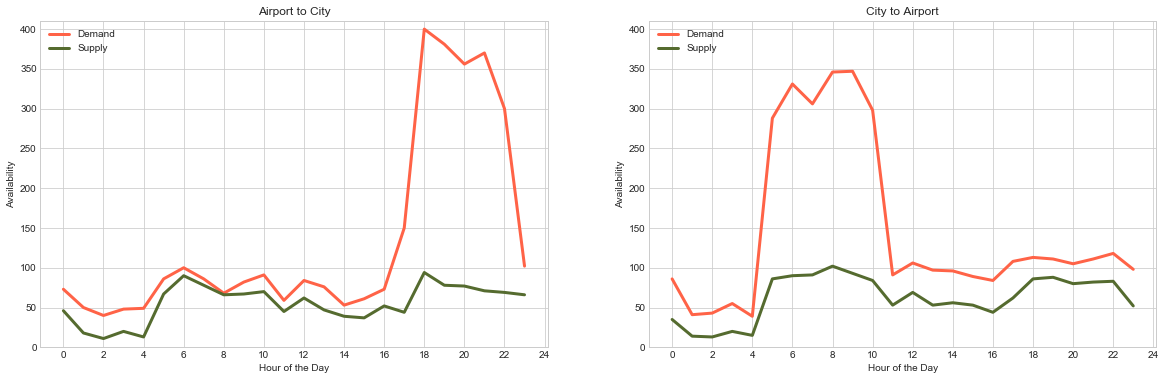

In [14]:
# Let's visualize supply-demand in both city and airport.

# 1. Before we begin, let's create a new supply-demand dataframe.
sup_dem_df = pd.DataFrame(columns=['Dem_in_Airport','Sup_in_Airport','Dem_in_City','Sup_in_City']) # create a new dataframe.
sup_dem_df['Dem_in_Airport'] = df[df['Pickup point']=='Airport'].groupby('req_hour')['Request id'].count()
sup_dem_df['Dem_in_City'] = df[df['Pickup point']=='City'].groupby('req_hour')['Request id'].count()
sup_dem_df['Sup_in_Airport'] = df[(df['Pickup point']=='Airport')&(df['Status']=='Trip Completed')].groupby('req_hour')['Request id'].count()
sup_dem_df['Sup_in_City'] = df[(df['Pickup point']=='City')&(df['Status']=='Trip Completed')].groupby('req_hour')['Request id'].count()
#print(sup_dem_df.head()) # uncomment to view the newly created dataframe.

# 2. We can plot now.
plt.figure(1, figsize=(20,6))

plt.subplot(121)
plt.title('Airport to City')
plt.ylim(0, 410)
plt.locator_params(axis='x', nbins=24) # control the number of x-tick marks.
plt.plot(sup_dem_df.Dem_in_Airport, 'tomato', label='Demand', linewidth=3.0)
plt.plot(sup_dem_df.Sup_in_Airport, 'darkolivegreen', label='Supply', linewidth=3.0)
plt.legend(loc='upper left')
plt.xlabel('Hour of the Day')
plt.ylabel('Availability')

plt.subplot(122)
plt.title('City to Airport')
plt.ylim(0, 410)
plt.locator_params(axis='x', nbins=24) # control the number of x-tick marks.
plt.plot(sup_dem_df.Dem_in_City, 'tomato', label='Demand', linewidth=3.0)
plt.plot(sup_dem_df.Sup_in_City, 'darkolivegreen', label='Supply', linewidth=3.0)
plt.legend(loc='upper left')
plt.xlabel('Hour of the Day')
plt.ylabel('Availability')

plt.show()

The plots above yet make the probelms clearer that we found out. For airport to city, the most evident gap is in the <b>evening-night</b> window. And for city to airport the gap is throught the day, although it becomes huge in the <b>morning rush-hour</b>.<br> <b>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

### Additional

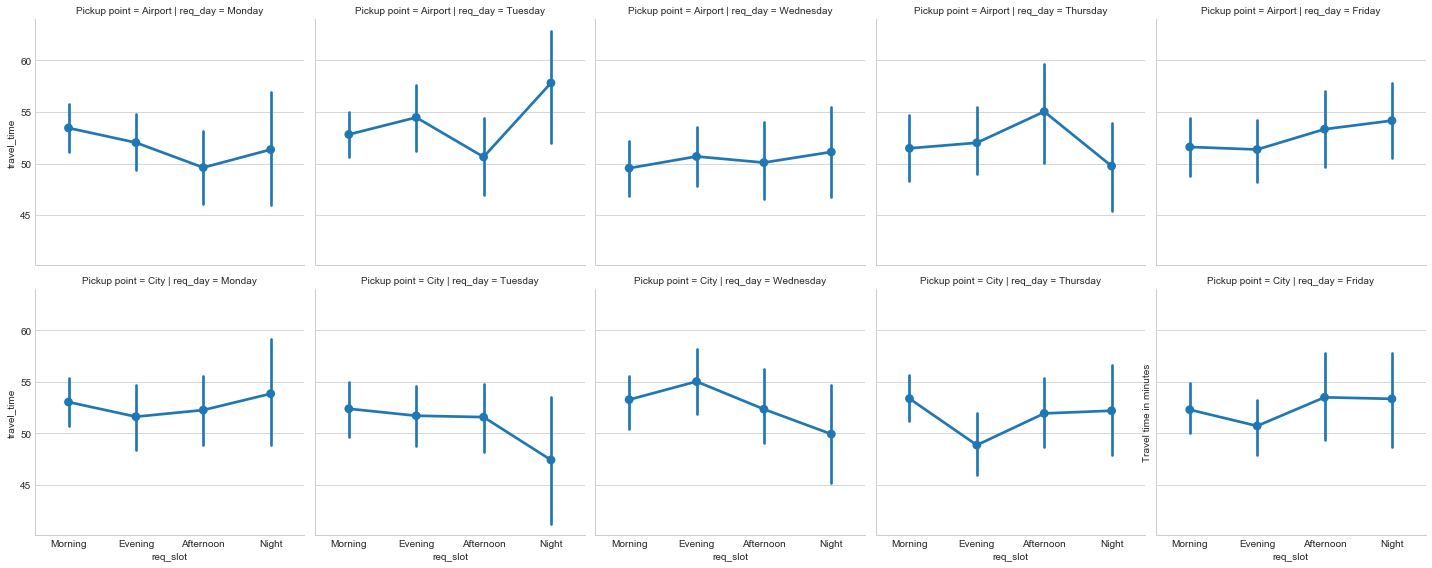

In [16]:
# Travel time variablility throughout different time slots as well as days of the week.

sns.factorplot(data=df, x='req_slot', y='travel_time', row='Pickup point', col='req_day')
plt.ylabel('Travel time in minutes')
plt.show()

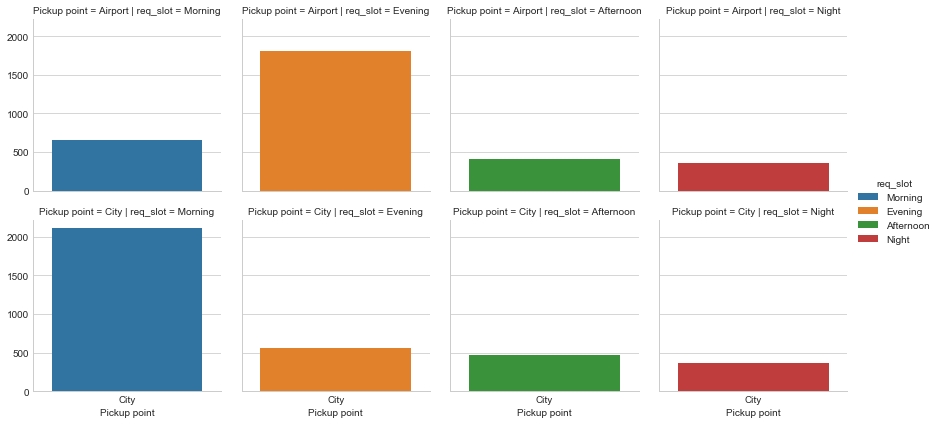

In [31]:
# Finding out number of requests throughout the day at different pickup oints.

g = sns.FacetGrid(df, row='Pickup point', col='req_slot', hue='req_slot')
g.map(sns.countplot, "Pickup point").add_legend()

People make high number of requests in the evening for Airport to city. And in case of City to Airport, people make more requests in the morning.

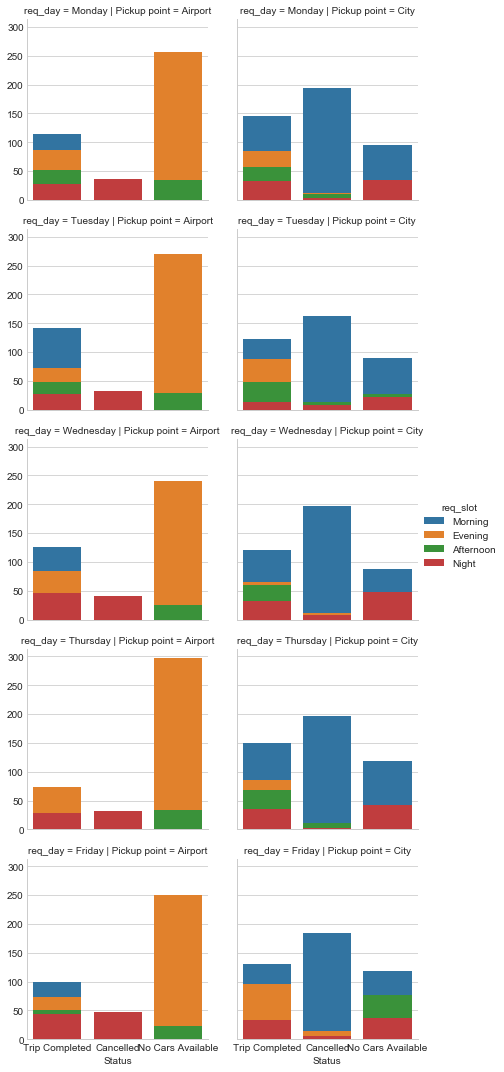

In [29]:
# Let's segment the above slot by days.

g = sns.FacetGrid(df, row='req_day', col='Pickup point', hue='req_slot')
g.map(sns.countplot, "Status").add_legend()

In case of Airport to City, major probelm of car availability arises in the evening. And in case of City to Airport, high number of cancellations are made in the morning. The pattern of problems is almost consistent irrespective of the days.

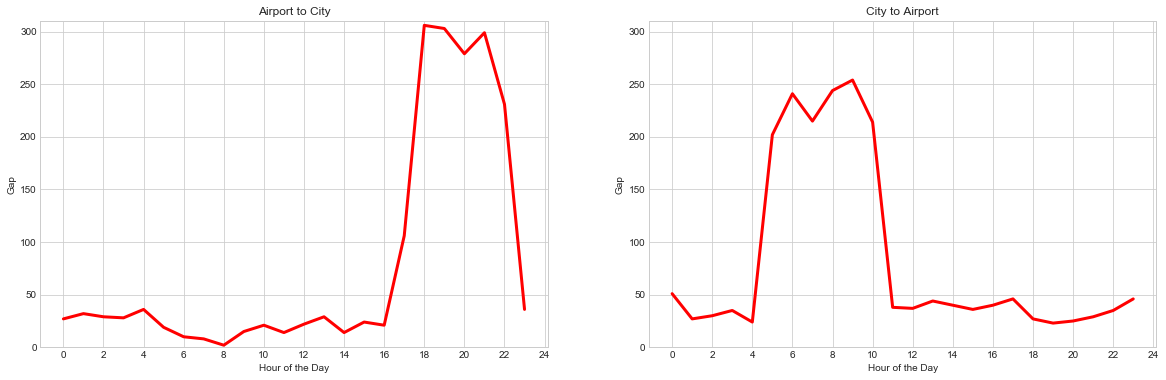

In [15]:
# The supply-demand can be plotted in the following way as well.

# 1. First, we create the columns with the supply-demand gap.
sup_dem_df['Air_to_City_gap'] = sup_dem_df['Dem_in_Airport'] - sup_dem_df['Sup_in_Airport']
sup_dem_df['City_to_Air_gap'] = sup_dem_df['Dem_in_City'] - sup_dem_df['Sup_in_City']
sup_dem_df.reset_index(inplace=True)

# 2. We can plot now.

plt.figure(1, figsize=(20,6))
plt.subplot(121)
plt.title('Airport to City')
plt.plot(sup_dem_df.Air_to_City_gap, 'r', linewidth=3.0)
plt.ylim(0,310)
plt.xlabel('Hour of the Day')
plt.ylabel('Gap')
plt.locator_params(axis='x', nbins=24)

plt.subplot(122)
plt.title('City to Airport')
plt.plot(sup_dem_df.City_to_Air_gap, 'r', linewidth=3.0)
plt.ylim(0,310)
plt.xlabel('Hour of the Day')
plt.ylabel('Gap')
plt.locator_params(axis='x', nbins=24)

plt.show()

In [ ]:
# We could have created the supply-demand columns in the original dataframe if we wanted.

#df['Dem_in_Airport'] = df[df['Pickup point']=='Airport'].groupby('req_hour')['Request id'].transform('count')
#df['Dem_in_City'] = df[df['Pickup point']=='City'].groupby('req_hour')['Request id'].transform('count')
#df['Sup_in_Airport'] = df[(df['Pickup point']=='Airport')&(df['Status']=='Trip Completed')].groupby('req_hour')['Request id'].transform('count')
#df['Sup_in_City'] = df[(df['Pickup point']=='City')&(df['Status']=='Trip Completed')].groupby('req_hour')['Request id'].transform('count')
#df.head()

In [ ]:
# Importing the csv files.

df.to_csv('df_cleaned.csv', encoding='utf-8', index=False)
sup_dem_df.to_csv('supply-demand.csv', encoding='utf-8', index=False)